In [96]:
import matplotlib.pyplot as plt
import numpy as np
from joblib import Parallel, delayed

import acoutreams

k0 = 2 * np.pi * 150000 / 343
materials = [acoutreams.AcousticMaterial(1050 + 100j, 2350 - 300j), acoutreams.AcousticMaterial(998, 1497)]
lmax = 3
radii = [0.005, 0.005]
positions = np.array(
    [
        [0.0075, 0, 0],
        [-0.0075, 0, 0],
    ]
)

spheres = [acoutreams.AcousticTMatrix.sphere(lmax, k0, r, materials) for r in radii]
tm = acoutreams.AcousticTMatrix.cluster(spheres, positions).interaction.solve()
inc = acoutreams.plane_wave_scalar([0, 0, tm.k0], k0=tm.k0, material=tm.material)
sca = tm.sca(inc)
xs = tm.xs(inc)

In [97]:
x = np.linspace(-0.02, 0.02, 101)
z = np.linspace(-0.02, 0.02, 101)
def compute_intensity(i, j, tm, radii, inc, sca):
    r = [x[j], 0, z[i]]
    result = 0  
    if tm.valid_points(r, radii): 
        result = 0.5 * np.abs(inc.pfield(r) + sca.pfield(r))**2  
    else:
        result = np.nan
    return i, j, result  

In [98]:
results = Parallel(n_jobs=-1)(
    delayed(compute_intensity)(i, j, tm, radii, inc, sca) for i in range(len(z)) for j in range(len(x))
)
intensity = np.zeros((len(z), len(x)))
for i, j, result in results:
    intensity[i, j] = result

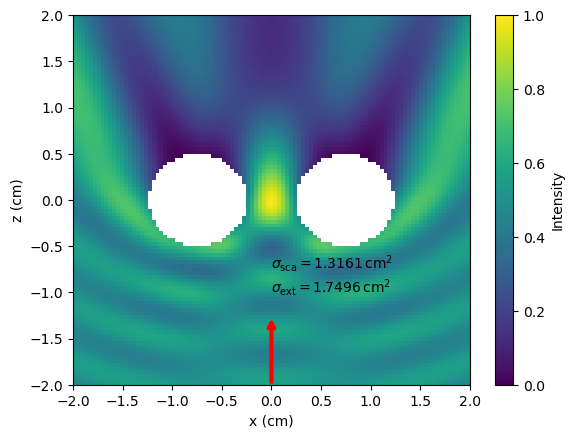

In [99]:
fig, ax = plt.subplots()
cax = ax.imshow(
    intensity, vmin=0, vmax=1,
    extent = [x.min() * 100, x.max() * 100, z.min() * 100, z.max() * 100],
    aspect='auto',
    origin='lower',
)
cb = plt.colorbar(cax)
cb.set_label("Intensity")
ax.set_xlabel("x (cm)")
ax.set_ylabel("z (cm)")
ax.text(
    0, -1,
    r"$\sigma_{\mathrm{sca}} = "
    f"{xs[0] * 10000:.4f}\,$cm$^2$\n"
    r"$\sigma_{\mathrm{ext}} = "
    f"{xs[1] * 10000:.4f}\,$cm$^2$"
)
ax.annotate(
    "", 
    xy=(0, -1.25),
    xytext=(0, -2), 
    arrowprops=dict(
        arrowstyle="->",
        lw=3, 
        color="red" 
    )
)
plt.show()

In [100]:
tm_global = tm.expand(acoutreams.ScalarSphericalWaveBasis.default(10))
sca = tm_global.sca(inc)

In [101]:
xs = tm_global.xs(inc)

In [102]:
results_global = Parallel(n_jobs=-1)(
    delayed(compute_intensity)(i, j, tm_global, [0.0125], inc, sca) for i in range(len(z)) for j in range(len(x))
)
intensity_global = np.zeros((len(z), len(x)))
for i, j, result in results_global:
    intensity_global[i, j] = result

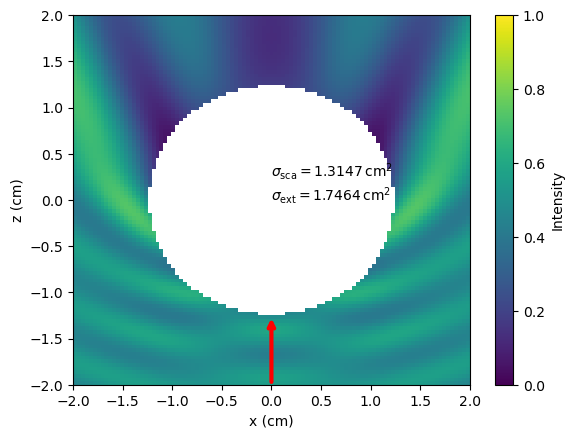

In [103]:
fig, ax = plt.subplots()
cax = ax.imshow(
    intensity_global, vmin=0, vmax=1,
    extent = [x.min() * 100, x.max() * 100, z.min() * 100, z.max() * 100],
    aspect='auto',
    origin='lower',
)
cb = plt.colorbar(cax)
cb.set_label("Intensity")
ax.set_xlabel("x (cm)")
ax.set_ylabel("z (cm)")
ax.text(
    0, 0,
    r"$\sigma_{\mathrm{sca}} = "
    f"{xs[0] * 10000:.4f}\,$cm$^2$\n"
    r"$\sigma_{\mathrm{ext}} = "
    f"{xs[1] * 10000:.4f}\,$cm$^2$"
)
ax.annotate(
    "", 
    xy=(0, -1.25),
    xytext=(0, -2), 
    arrowprops=dict(
        arrowstyle="->",
        lw=3, 
        color="red" 
    )
)
plt.show()

In [104]:
inc = acoutreams.plane_wave_scalar([k0, 0, 0], k0=tm.k0, material=tm.material)
tm_rotate = tm_global.rotate(0, np.pi / 2)
sca = tm_rotate.sca(inc)

In [105]:
xs = tm_rotate.xs(inc)

In [106]:
results_rotate = Parallel(n_jobs=-1)(
    delayed(compute_intensity)(i, j, tm_rotate, [0.0125], inc, sca) for i in range(len(z)) for j in range(len(x))
)
intensity_rotate = np.zeros((len(z), len(x)))
for i, j, result in results_rotate:
    intensity_rotate[i, j] = result

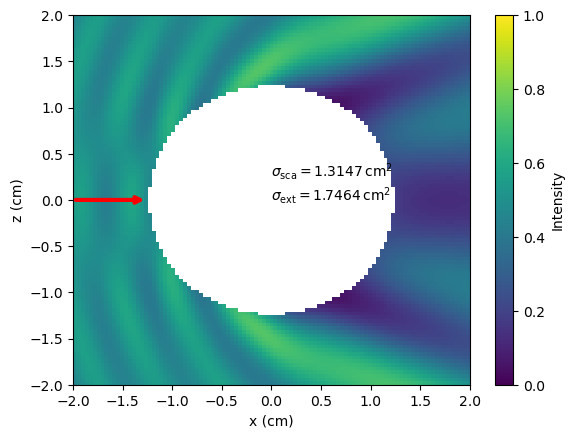

In [107]:
fig, ax = plt.subplots()
cax = ax.imshow(
    intensity_rotate, vmin=0, vmax=1,
    extent = [x.min() * 100, x.max() * 100, z.min() * 100, z.max() * 100],
    aspect='auto',
    origin='lower',
)
cb = plt.colorbar(cax)
cb.set_label("Intensity")
ax.set_xlabel("x (cm)")
ax.set_ylabel("z (cm)")
ax.text(
    0, 0,
    r"$\sigma_{\mathrm{sca}} = "
    f"{xs[0] * 10000:.4f}\,$cm$^2$\n"
    r"$\sigma_{\mathrm{ext}} = "
    f"{xs[1] * 10000:.4f}\,$cm$^2$"
)
ax.annotate(
    "", 
    xy=(-1.25, 0),
    xytext=(-2, 0), 
    arrowprops=dict(
        arrowstyle="->",
        lw=3, 
        color="red" 
    )
)
plt.show()